# Projet Notations de films 

Dans le cadre du Projet Data Science nous avons choisi d'étudier l'appréciation des films par les utilisateurs de la plateforme Allociné et par la presse. Nous cherchons les déterminants des notes attribuées sur le site en considérant plusieurs variables (le genre du réalisateur, la durée du film, les récompenses institutionnelles, etc). Nous avons également cherché à comparer les notes données par les spectateurs et celles données par la presse. 

Pour cela nous nous nous basons sur la base Allociné et base française CNC.

Le rapport se décompose de la manière suivante :   

I - Création de la base de données

1) Base Allociné  

2) Base CNC


II - Analyses descriptive des données

1) Analyses générales sur les notes attribuées aux films en fonction du genre du film

2) Analyses sur d'autres variables

3) Comparaison appréciation spectateurs et presse

4) Analyses plus subtiles sur le genre à partir de la base CNC

5) Analyses sur le budget à partir de la base CNC


III - Modélisation

1) Peut-on prédire les notes des spectateurs à partir de caractéristiques des films ?

2) Peut-on regrouper les presses en fonction de leur appréciations aux divers films ?


In [ ]:
# Stockage et lecture des fichiers
import csv
import os
import requests

# Web scraping et traitement de texte
from bs4 import BeautifulSoup
import re
import s3fs

# Traitement et visualisation de données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Importation des fichiers python (contenant des fonctions) crées dans le cadre des 3 parties du projet :

for f in os.listdir('A_Base_de_données'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from A_Base_de_données.{module_name} import *")

for f in os.listdir('B_Analyse_descriptive'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from B_Analyse_descriptive.{module_name} import *")

for f in os.listdir('C_Modele'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from C_Modele.{module_name} import *")


## I - Création de la base de données

### 1) Base AlloCiné

Pour répondre à notre problématique, nous avons besoin de données sur les films (notes, budget, etc.). Nous avons donc choisi de récupérer les données du site français Allociné. N'ayant pas d’api publique, il a fallu recourir à la méthode du **web scraping**. Notre travail a été facilité par la structure du site : *pages web standardisées et non dynamiques*, *pages regroupant tous les films selon une année/décennie ou un genre*.




Pour gagner en efficacité, nous avons utilisé la technique du web scraping **asynchrone**, qui permet d'envoyer plusieurs requêtes simultanément, optimisant ainsi les temps d’exécution. L'un des risques lié à cette méthode est que nos requêtes soient interprétées comme des attaques DDOS par le site, mais nous nous limitons à une dizaine de requêtes par secondes (*il faudrait plusieurs centaines de milliers de requêtes pour une alerter le service !*). 

Ce dernier point, ouvre une question plus globale, celle de la légalité du web scraping. Alors que la création de ces données est coûteuse pour allociné, les web scrapeurs ne versent aucune compensation. **Nous nous sommes assurés que notre travail entrait bien dans la légalité : l’article L. 342-3 du Code de la propriété intellectuelle dispose que le web scrapping est légal das le cas d'une utilisation à des fins de recherche ou pédagogique.**

Le processus de web scraping est effectué année par année. Les liens des films sont récupérés **uniquement s'il existe des notes de presse et de spectateurs pour ces films**. Dans ce cas, les caractéristiques des films sont également collectées. 

In [ ]:
# Récupération d'une liste de films possédant tous une note moyenne de SPECTATEUR et une note moyenne de PRESSE 
# avec plusieurs caractéristiques : titre, durée, genre, nom du réalisateur, etc

# Exemple de webscrapping d'UNE année (temps estimé à moins de 2 minutes)
table_wbs_exemple = get_base_final(2011,2012)

La base générée par webscrapping utilisée dans le rapport comprend les films de **2001** à **2024**, pour lesquels nous avons au moins la moyenne des spectateurs et la note moyenne attribuée par la presse. La construction de cette table prenant une vingtaine de minutes (et son contenu pouvant varier en fonction du moment où a lieu le webscrapping), une fois générée, la table a été enregistrée au sein du SSP Cloud.

In [72]:
# Lecture de la base CSV (sauvegardée dans le SSP Cloud car le webscrapping qui prend un peu de temps (et les données changent régulièrement)) :

# Création du chemin
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "roux"

chemin = f"{MY_BUCKET}/projet_python/base_allocine.csv"

# Importation
with fs.open(chemin, "r") as file_in:
    table_films = pd.read_csv(file_in)

**Si le code précédent ne fonctionne pas (ou bien que vous n'êtes pas sur le SSPCloud, veuillez exécuter le code suivant) :**

In [74]:
# Si le code précédent ne fonctionne pas 
url = "https://minio.lab.sspcloud.fr/roux/projet_python/base_allocine.csv"
table_films = pd.read_csv(url)

Traitement de la base Allociné (Mise en forme et création de variables)

In [76]:
####### Nettoyage et mise en forme

# Conversion des notes en écriture décimale
table_films['spectators_rating'] = table_films['spectators_rating'].apply(mise_en_forme_decimale)
table_films['press_rating'] = table_films['press_rating'].apply(mise_en_forme_decimale)



######## Créations de variables

# Ajout du genre des réalisateurs (en se basant sur une base de plus de 11 627 prénoms de plusieurs pays dont le genre est mentionnés : femmes f, hommes m et prénoms mixtes f,m)
table_films = get_genre_individuel(table_films, 'director')


# Année du film
table_films = get_annee(table_films, 'date')               

# Durée du film en minutes
table_films['duration'] = table_films['duration'].astype('string')
table_films['duration_min'] = table_films['duration'].apply(duree_en_minutes)

# Variable catégorielle du type de récompenses (prix, nomination, rien)
table_films['categorie_recompenses'] = table_films['recompenses'].apply(get_cat_recompenses)

# Créations de variables pour stocker du nombre de nominations et nombre de prix par film
table_films[['prix', 'nominations']] = table_films['recompenses'].apply(lambda x: pd.Series(get_laureat_nomination(x)))
 

# Création d'un dataframe, contenant les notes de chaque film par presse + Traduction des notes en numérique (Très bien => 4, etc)
presse = table_films.iloc[:, [1] + list(range(27, 80))]
presse_notes = equivalence_notes(presse)
presse_notes.set_index('identifiant', inplace=True)



/home/onyxia/work/Projet_Cin-/A_Base_de_données/mise_en_forme.py:99: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  notes = dataframe.replace(equivalences)


In [77]:
print('La table Allociné contient', len(table_films), 'films')

La table Allociné contient 10837 films


### 2) Base CNC

Afin d'enrichir nos données, nous avons décidé de nous appuyer également sur la base des longs métrages agréés par le CNC (Centre National du cinéma). Cette base nous permet de recueillir des informations liées au conditions de production des films (nom des sociétés de production, montant du devis déclaré...). Nous pouvons ainsi conduire une analyse plus spécifique sur l'appréciation du cinéma français, que nous croisons avec ces nouvelles données.

In [62]:
# Importation des données du CNC en utilisant un API.
api_root = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/cnc-production-cinematographique-liste-des-films-agrees/exports/json?limit=-1"
response = requests.get(api_root)
films_cnc_brut = response.json() 
print(response.content[:1000])

films_cnc = pd.json_normalize(films_cnc_brut) 

b'[{"visa": "117042", "titre": "BYE BYE BLONDIE", "realisateur": "DESPENTES Virginie", "producteurs": "MASTER MOVIES / RED STAR CINEMA / WILD BUNCH", "devis": 4103906.0, "genre": "Fiction", "eof": null, "rang": "2", "asr": "avant", "payante": null, "clair": null, "nationalite": ["France", "Belgique", "Suisse"], "date": "2010", "decomposition": "France-65 / Belgique-21 / Suisse-14", "aides": ["Sofica"]},{"visa": "127028", "titre": "DE L\'HUILE SUR LE FEU", "realisateur": "BENAMOU Nicolas", "producteurs": "AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / TF1 DROITS AUDIOVISUELS / UGC IMAGES", "devis": 3320336.0, "genre": "Fiction", "eof": null, "rang": "1", "asr": null, "payante": null, "clair": null, "nationalite": ["France"], "date": "2010", "decomposition": "France-100", "aides": ["Sofica", "Cr\\u00e9dit D\'impot"]},{"visa": "124421", "titre": "DES JEUNES GENS MODERNES", "realisateur": "DE MISSOLZ J\\u00e9r\\u00f4me", "producteurs": "ARTE FRANCE CINEMA / LOVE STREAMS AGNES B. PRODUCTIONS

In [ ]:
# Categorisation des films en fonction du montant du devis (nous nous appuyons sur une typologie utilisée dans la littérature de sociologie du cinéma)
films_cnc = categorisation_devis(films_cnc)

# Ajout d'une variable genre du réalisateur (nous utilisons la même base de plus de 11 627 prénoms de plusieurs pays)

# ATTENTION cela peut prendre un peu moins de 3 minutes (sur le SSPCloud)
films_cnc = ajout_genre_multiple(films_cnc, 'realisateur')

# Nettoyage
films_cnc.loc[films_cnc["genre"] == "Docu", "genre"] = "Documentaire"

In [64]:
print('La table CNC contient', len(films_cnc), 'films')

La table CNC contient 4620 films


In [65]:
# Fusion base CNC et base allociné (réduction de la base sur les films français présent dans la base CNC)
base_allocine = table_films.drop(columns=['titre', 'genre_ind'])
base_cnc_agregee = pd.merge(films_cnc, base_allocine,left_on='visa', right_on='num_visa', how='inner')


In [66]:
print('La table fusionnée contient', len(base_cnc_agregee), 'films')

La table fusionnée contient 2843 films


## II -  Analyses descriptives

### 1) Analyses descriptives générales des notes des spectateurs en fonction du genre du film

Nous avons à notre disposition une base de **10 837** films, contenant des caractéristiques telles que le genre du film, le nom du réalisateur, l'année de production, les récompenses reçues, la **note moyenne** attribuée par les utilisateurs de la plateforme Allociné (que nous appelerons **spectateurs** dans notre étude) ainsi que celle attribuée par **la presse**. Les notes vont de **1 à 5**.

Dans un premier temps, nous nous intéressons aux genres les plus appréciés en moyenne par les spectateurs. Pour ce faire, nous considérons la typologie des genres présente sur le site Allociné, en écartant de l'analyse les genres enregistrant moins de 50 films.

In [45]:
# (A noter que les genres dont nous possédons moins de 50 films n'apparaissent pas dans le classement).
classement_genres_preferes(table_films, 'spectators_rating')

,Note_Moyenne,Nombre_de_Films
genre,,
Biopic,3.41,345
Animation,3.25,509
Drame,3.11,4143
Aventure,3.07,568
Policier,3.02,342
Comédie dramatique,2.95,891
Action,2.91,954
Science Fiction,2.85,50
Thriller,2.79,257


Les films **Biopic**, d'**Animation** et **Drame** semblent être les plus appréciés par les spectateurs. Tandis que les films de **Comédie**, **Fantastique** ou encore d'**Epouvante-horreur** semblent relativement moins appréciés. 

A noter que les effectifs au sein de chaque genre de films peuvent être assez variables (allant de 50 pour la Science Fiction à plus de 4000 pour les Drames). De ce fait, il peut être intéressant de comparer de manière plus précise les **notes moyennes** attribuées par les **spectateurs** afin de voir si les différences dans la **notation des spectateurs** en fonction du **genre de film** sont significatives ou pas. 

Pour cela, nous pouvons regarder la distribution des notes à l'aide d'un **histogramme**, et réaliser un test **ANOVA** sur les différents groupes. Cette méthode statistique permet de déterminer si au moins une des moyennes parmi les groupes étudiés est significativement différente des autres, en tenant compte de la variabilité au sein et entre les groupes.

Dropdown(description='Genre 1 :', index=10, options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', 'Aven…

Dropdown(description='Genre 2 :', index=5, options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', 'Avent…

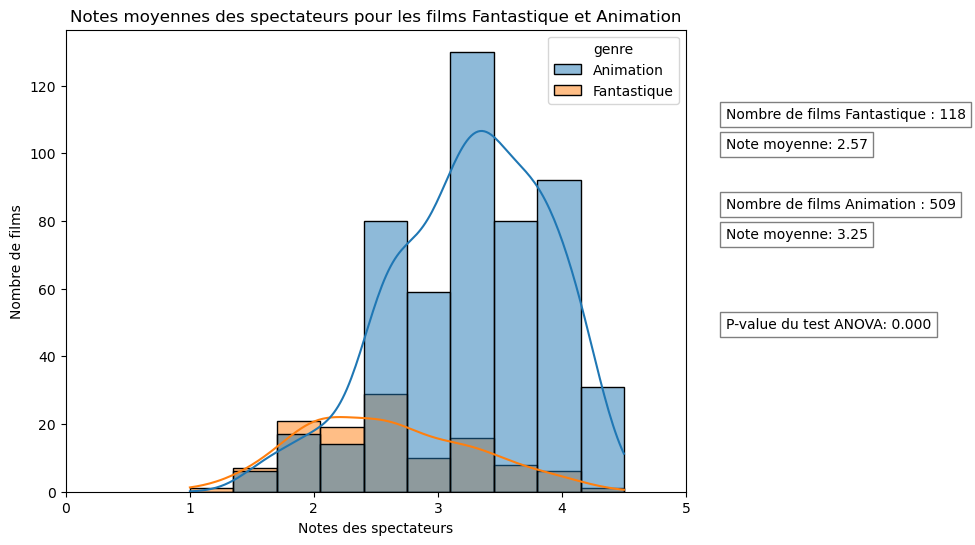

In [ ]:
# Histogrammes de la distribution des notes attribuées par les spectateurs en fonction du genre du film
# => Les menus déroulants permettent de sélectionner différents genres à comparer 
# => Les genres dont nous possédons moins de 50 films ne sont pas pris en compte pour les comparaisons des genres par deux.                

menu_deroulant_histogramme(table_films,'genre1') 

# ATTENTION : À noter qu'au vu du grand nombre de films, l'affichage peut prendre un peu de temps une fois les genres sélectionnés

Les différentes distributions des genres de films montrent que la plupart des genres présentent une tendance proche de la normale, avec au moins une valeur pic distincte.

Une p-value du test d'ANOVA très faible (inférieure aux seuils usuels, et notamment de 5%), indique que la différence de notation des spectateurs entre les genres de films peut être considérée comme significative. En étudiant les différentes distributions de notes en fonction des genres ainsi que les tests ANOVA associés, nous pouvons remarquer les points suivants :


- L'ANOVA sur tous les types de films (**p-value < 0.01**) montre qu'il existe bien des **différences significatives** au sein des groupes (au moins un groupe se distingue des autres), cependant cela ne donne aucune information sur quels sont les groupes statistiquement significatifs. Pour cela, nous pouvons par exemple les comparer deux par deux. 


- Pour certains genres de films qui étaient très proche dans le classement, leur p-value montrent que les différences de notations ne sont pas très significatives (Tels que **Action** et **Comédie Dramatique** avec 0,19), voir pas du tout significatives (avec des valeurs de p-value supérieures à 0,6 pour SF et Action par exemple).

- Mais certains genres qui étaient très proches au niveau de la notation moyenne, se retrouvent à avoir des différences de notation qui peuvent être considérées comme statistiquement significatives. C'est notamment le cas du genre **Animation** et **Aventure**, respectivement aux deuxième et troisième places, significatives au seuil de 1%.

- Nous remarquons, comme attendu, que pour un genre considéré plus le genre de comparaison est éloigné de lui dans le classement, plus le test de différenciation des groupes est significatif. 

Les diverses ANOVA réalisées laissent supposer que le type de films semblerait avoir un lien avec la note attribuée par les spectateurs.

### 2) D'autres caractéristiques pourraient-elles avoir une influence sur l'appréciation attribuée par les spectateurs ?

De manière similaire à précédemment nous pouvons effectuer un test **ANOVA** sur le **genre du réalisateur** afin de voir s'il existe une différence significative dans les notes moyennes attribuées aux films réalisés par des femmes et aux films réalisés par des hommes.

In [47]:
p_value_anova_h_vs_f(table_films)

P-value du test ANOVA: 0.241


Avec une p-value bien supérieure aux seuils habituels de 1, 5 et 10%, nous pouvons dire qu'il ne semble **pas** y avoir de **différence** statistiquement significative entre les notes attribuées par les spectateurs pour des films réalisés par des femmes et des films réalisés par des hommes. 

Nous pouvons aussi nous pencher sur la durée des films, en traçant le boxpolt des notes en fonction de la durée des films (durées qui ont été discrétisées en intervalle de 10 minutes) : 

/home/onyxia/work/Projet_Cin-/B_Analyse_descriptive/Fonctions_diverses.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['duree_cat'] = pd.cut(dataframe[variable], bins=bins, labels=labels, right=False)


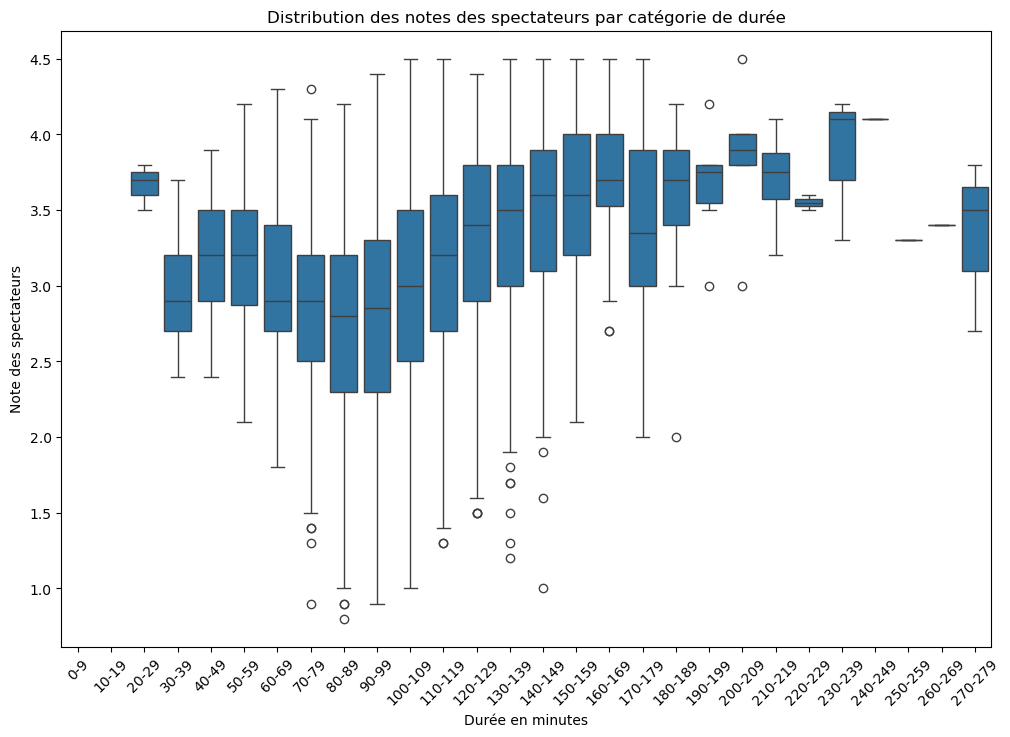

In [48]:
boxplot_duree(table_films, 'duree_cat')

Le boxplot laisse entrevoir deux tendances linéaires : 
- décroissante pour les films de courtes durées jusqu'à 80 minutes
- croissante pour les films avec des durées supérieures à 80 minutes

Cependant, ces tendances ne semblent pas statistiquement significatives.

En se basant sur les récompenses obtenus par les films, nous pouvons regarder la moyenne de la note attribuée aux films qui ont :
- Au moins un prix (éventuellement aussi des nominations)
- Une ou des nominations (mais pas de prix)
- Aucune récompense

In [49]:
get_moyenne_par_modalite(table_films, 'categorie_recompenses')

,presse,spectateur
categorie_recompenses,,
aucune récompense,2.95,2.86
nominations,3.16,2.99
prix,3.47,3.31


Nous remarquons que plus les films ont de meilleures récompenses (prix > nominations > aucune récompense), plus la note moyenne attribuée par les spectateurs est élevée.

### 3) Les préférences des spectateurs sont-elles similaires à celles de la presse ?

Nous avons précédemment regardé le classement des genres de films les plus appréciés par les spectateurs. Comparons maintenant ce classement à celui de la presse :

In [50]:
comparaison_preferences(table_films)

,Note_Moyenne,Nombre_de_Films
genre,,
Biopic,3.41,345
Animation,3.25,509
Drame,3.11,4143
Aventure,3.07,568
Policier,3.02,342
Comédie dramatique,2.95,891
Action,2.91,954
Science Fiction,2.85,50
Thriller,2.79,257


Le classement se ressemble avec un même trio en tête. En queue de classement, nous retrouvons dans les deux cas les genres Thriller, Epouvante-horreur et Comédie. Cependant le genre Action, en milieu de classement pour les spectateurs, se retrouve en bas du classement pour la presse.
De plus, les notes moyennes des spectateurs semblent tenir globalement sur un intervalle plus large que celui de la presse.

Dropdown(description='Genre :', options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', 'Aventure', 'Anim…

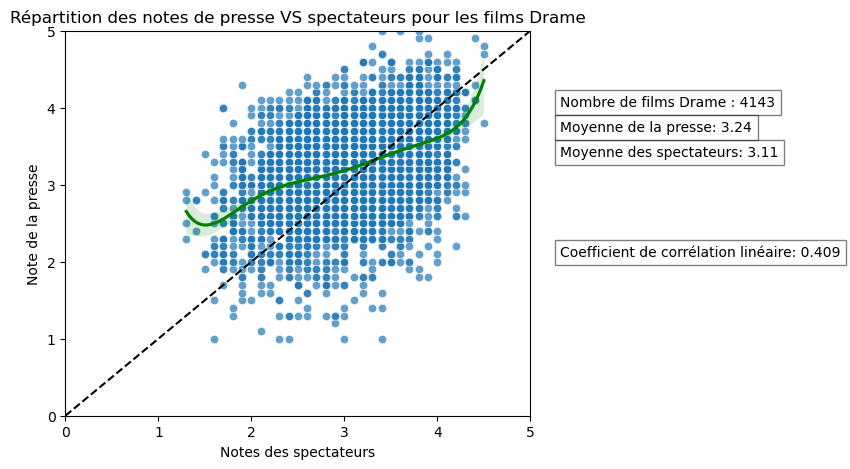

In [51]:
# Nuage de points pour voir les différences de notations entre la presse et les spectateurs
# => Le polynôme en vert représente le polynôme optimal (avec degré max 6), trouvé par validation croisée 
# => Comparer ce poynôme avec la droite x = y (en pointillé) permet de voir si les notes de la presse
# et des spectateurs sont relativement semblables ou non

graphique_presse_vs_spect(table_films) 

Pour la plupart des genres de film, nous pouvons observer une **nette plus grande dispersion** des notes des **spectateurs** par rapport à celles de la **press**e. Ce qui refléterait la nature plus **hétérogène** des évaluations des spectateurs comparées aux critiques de la presse.

Avec un coefficient de corrélation linéaire de 0,53 (en prenant en compte tous les films), nous avons une **relation positive modérée** entre les notes de la presse et des spectateurs. Nous avons une influence modérée des critiques de presse sur les opinions des spectateurs.

En regardant par type de film, nous nous apercevons que nous pouvons distinguer 3 catégories de films :
- Les films un peu plus corrélés que la moyenne des films (corrélation entre 0,6 et 0,7 pour Aventure, Animation, Epouvante Horreur et Science Fiction)
- Les films corrélés dans la moyenne des films (Policier, Thriller, Comédie et Action)
- Les films très peu corrélés (Comédie dramatique, Biopic, Fantastique et Drame)


Afin d'avoir une analyse plus fine, notamment en terme de budget alloué au film ainsi que le genre du/des réalisateurs nous pouvons agréger à nos films, la base française CNC. Nous perdrons un certains nombre de films, mais en contrepartie cela nous permet d'avoir des variables plus précises pour certaines caractéristiques : notamment sur le(s) genre(s) des réalisateurs ainsi que les budgets alloués aux films.

### 4) Une analyse plus fine du genre à partir d'un périmètre d'étude plus réduit : le cas des films agréés de la base CNC

Nous souhaitons dans cette partie approfondir les résultats de la partie précédente. Nous avons vu qu'il n'existait pas de différence statistiquement significative dans la base allociné en termes d'appréciation des films par les spectateurs selon le genre du réalisateur. Nous souhaitons, malgré tout, aller plus loin dans l'analyse. Nous nous interrogeons sur l'existence de discrimination de genre de manière générale dans l'accès à la profession de réalisateur et dans la réception des oeuvres. Nous considérons dans cette partie la base CNC, nous restreignant ainsi au cinéma français. 

Dans un premier temps, nous nous assurons que la fonction chargée de créer la variable genre du réalisateur a bien fonctionné et que nous n'avons pas trop de perte d'information.

In [67]:
films_cnc["genre_ind"].value_counts() # 'f,m' signfie que le genre du prénom est mixte

genre_ind
m                     2535
non trouvé             888
f                      713
m_coréalisé            266
f,m                    110
f_coréalisé            106
pas de realisateur       2
Name: count, dtype: int64

Dropdown(description='Genre du film :', index=2, options=('Fiction', 'Documentaire', 'Animation', 'Anim', 'Tou…

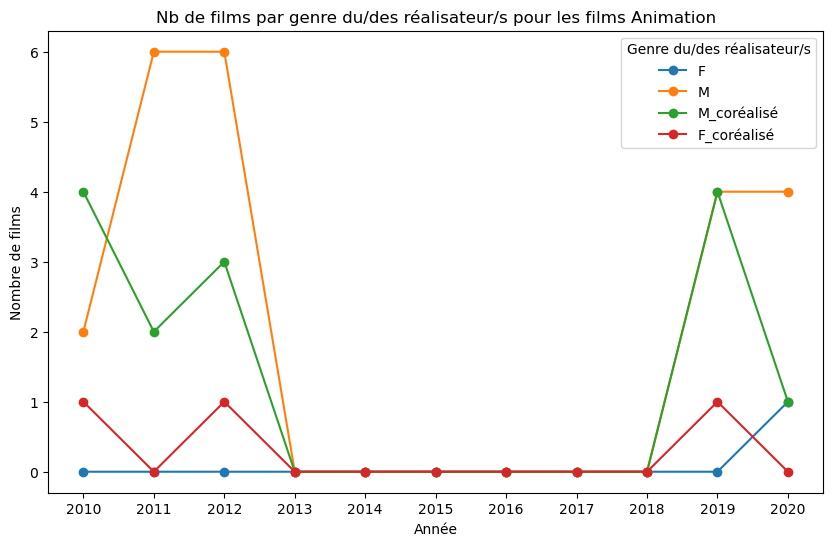

In [68]:
# Dans la base CNC 4 genres sont présents : Fiction, Documentaires, Animation et Anim
graphique_h_f_cnc(films_cnc)

Ce graphique nous informe que **la production cinématographique française agréée est beaucoup plus masculine que féminine** et ce, sur l'ensemble de la période considérée, et pour tous les genres considérés.

Nous allons tenter d'explorer davantage les données pour essayer de comprendre les mécanismes pouvant expliquer cette différence. Nous étudions les types de devis accordés à des films réalisés par des femmes, par des hommes, par plusieurs réalisateurs hommes (h_coréalisé), par plusieurs réalisateurs dont au moins une femme (f_coréalisé)

/home/onyxia/work/Projet_Cin-/B_Analyse_descriptive/Fonctions_diverses.py:145: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = dataframe.groupby([variable, 'genre_ind']).size().reset_index(name='count')


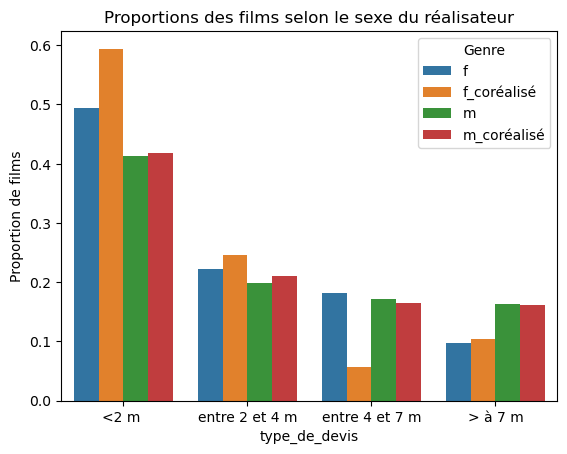

In [56]:
diagramme_baton_genre_proportion(films_cnc, "type_de_devis")

Nous voyons ici que les films réalisés par des femmes bénéficient moins que ceux réalisés par les hommes de devis évalués à plus de 7 millions d'euros (10% contre environ 17%). A l'inverse, 50 % de la production cinématographique féminine est financée par des devis inférieurs à 2 millions d'euros, contre 40 % pour la production cinématographique exclusivement masculine.

Nous récupérons maintenant les informations contenues dans la base allociné, afin de pouvoir croiser la variable genre avec la variable des **récompenses** (qui est un indicateur de la reconnaissance institutionnelle).

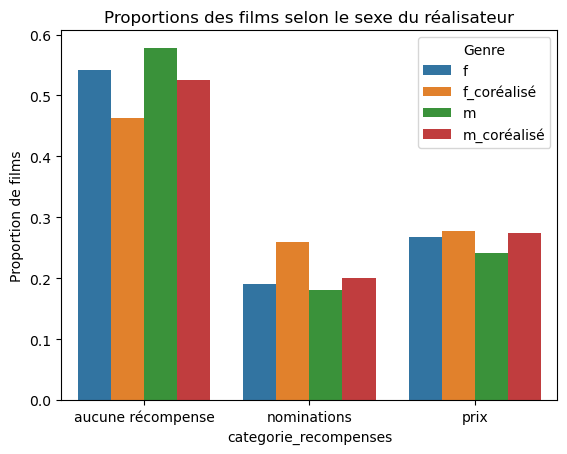

In [79]:
diagramme_baton_genre_proportion(base_cnc_agregee, 'categorie_recompenses')

Il ne semble pas y avoir de différence de performance des films réalisés par des femmes contre ceux réalisés par leurs homologues masculins aux festivals de cinéma.

### 5) Les variations de notation de la presse et des spectateurs selon le budget alloué aux films

Dropdown(description='Type devis 1 :', index=2, options=('<2 m ', 'entre 2 et 4 m', 'entre 4 et 7 m', '> à 7 m…

Dropdown(description='Type devis 2 :', options=('<2 m ', 'entre 2 et 4 m', 'entre 4 et 7 m', '> à 7 m'), value…

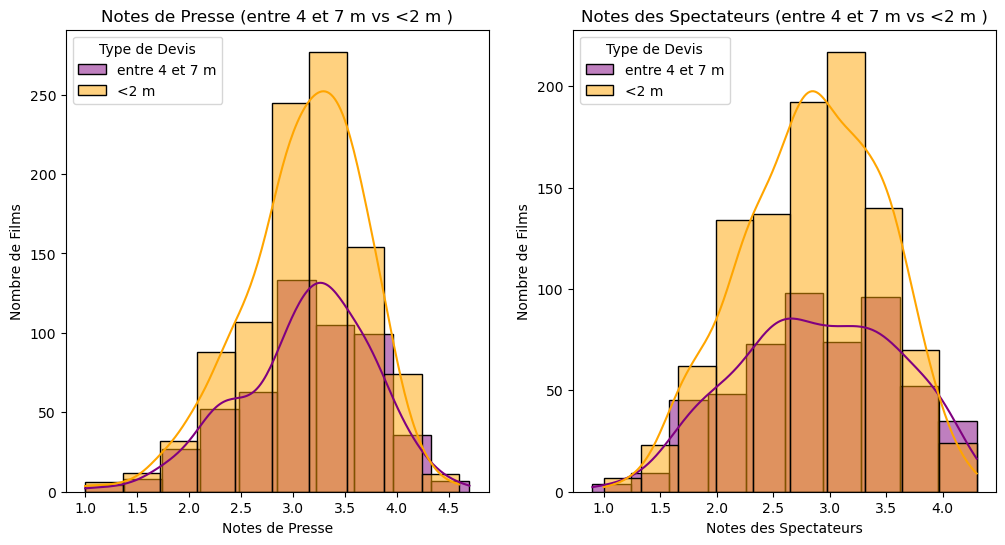

In [ ]:
menu_deroulant_histogramme(base_cnc_agregee, "type_de_devis")

A l'aune de ce graphique, nous pouvons conclure que les appréciations de la presse sont plus sensible à la modalité de devis "supérieur à 7 millions d'euros" (la distribution tend à suivre une loi normale) que celles des spectateurs (leur appréciation suit une loi plus semblable à une loi uniforme).

Mis à part pour cette catégorie de devis, nous pouvons remarquer qu'au sein de chaque population, le type de devis ne semble pas avoir de grande influence sur les notes données (distributions relativement similaires).

## III - Modélisation

### 1) Peut-on prédire les notes des **spectateurs** à partir de caractéristiques des films ?

La première analyse descriptive montre que l'on distingue différents facteurs qui pourraient expliquer des différentes notes attribuées par les spectateurs. Nous pouvons voir si un modèle permettrait d'expliquer et prédire les notes des spectateurs en se basant sur divers critères, tels que le genre, la durée ou encore les récompenses obtenus.  

In [25]:
# Suppression des lignes qui n'ont pas de durée renseignée (seulement 24 sur les 10837 films)
table_regression = table_films.dropna(subset=['duration_min'])

# Filtrage poru ne conserver que les modalités de genre de films présentes plus de 50 fois 
modalites_conservees = classement_genres_preferes(table_regression, 'spectators_rating').index.tolist()
table_regression = table_regression[table_regression['genre1'].isin(modalites_conservees)]

In [26]:
# test de normalité de la distribution des notes
stat, p_value = shapiro(table_films['spectators_rating'])
print('p-value :', p_value)

p-value : 2.6021836323601493e-31


/opt/conda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10837.
  res = hypotest_fun_out(*samples, **kwds)


La très faible p-value montre que nous pouvons fortement rejeter l'hypothèse de normalité des données. La regression se fera ainsi avec la normalisation des notes au préalable.

MSE : 0.3619
R² : 0.2069

ATTENTION : Les coefficients sont ceux de la régression avec les notes normalisées.

              Variable  Coefficient  Lower CI  Upper CI
0            Animation     0.796880  0.676040  0.917720
2               Biopic     0.518301  0.385125  0.651477
5                Drame     0.320408  0.243108  0.397708
1             Aventure     0.295440  0.183894  0.406985
15        duration_min     0.199747  0.178483  0.221011
4   Comédie dramatique     0.153294  0.054145  0.252443
8             Policier     0.150107  0.014674  0.285540
14                prix     0.129193  0.100910  0.157476
13         nominations     0.128441  0.101001  0.155880
11                 f,m    -0.019610 -0.127140  0.087920
12                   m    -0.066631 -0.110167 -0.023095
10            Thriller    -0.067381 -0.217125  0.082363
9      Science Fiction    -0.133382 -0.460002  0.193238
3              Comédie    -0.186311 -0.269528 -0.103095
6    Epouvante-horreur    -0.441570 -0.586590 -0.

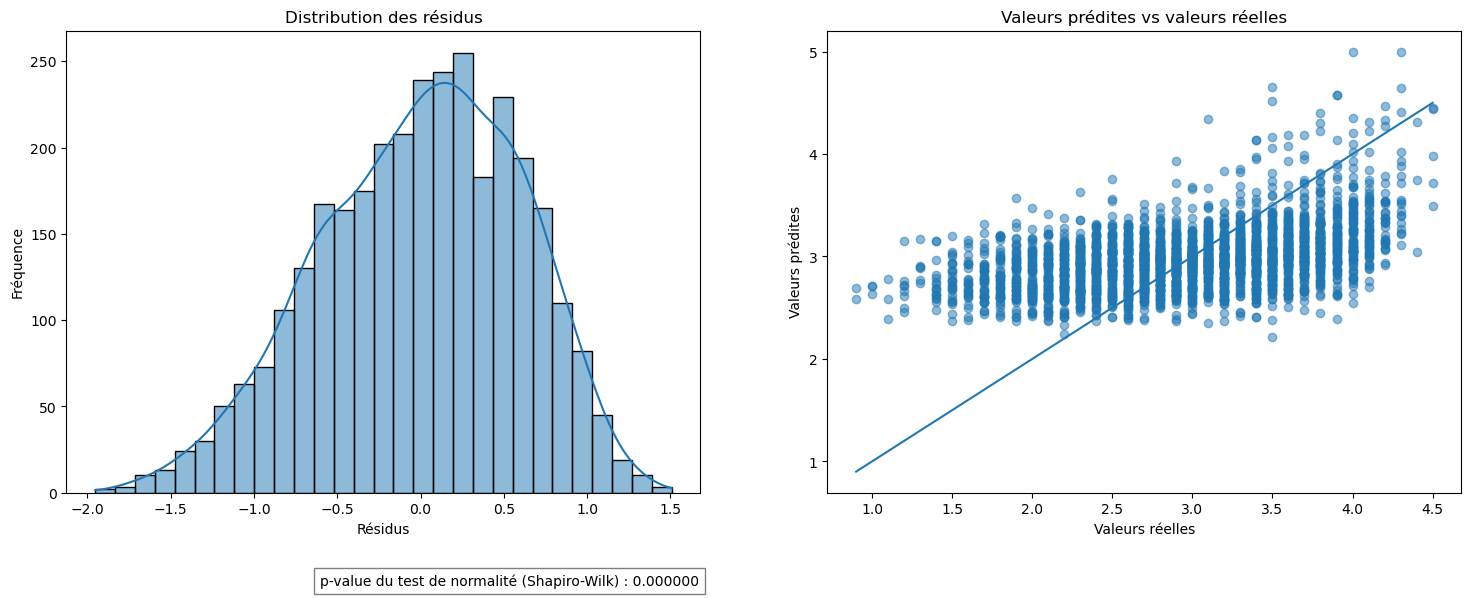

In [17]:
regression(table_regression)

Afin de gérer les variables discrètes dans la regression, chaque modalité fait l'objet d'une variable binaire. Les modalités de références (utilisées comme base de comparaison, non présentes, elles n'ont pas de coefficients afin de ne pas avoir de problème de multicolinéarité) sont : **Action**, pour les variables concernant le genre du film, et **femme (f)** pour le genre du réalisateur.

Les variables continues ont été normalisées (**durée du film**, nombre de **prix** et nombre de **nominations**) afin d'avoir des échelles de valeurs comparables.


Les **coefficients** de la régression (coefficients avec variable cible normalisée), montrent que : 
- Certains coefficients ne sont pas statistiquement significatifs (leur intervalles de confiance à 95% incluent 0). *Exemple : Le fait d'être un Thriller par rapport à Action*
- Certains coefficients sont statistiquement significatifs mais ont un poids assez faible. *Exemple : Le fait d'avoir un réalisateur masculin (m) ou bien un prénom mixte (f,m) par rapport à une réalisatrice (avec à chaque fois un coefficient associé à cette variable légèrement négatif).*
- Les coefficients qui semblent avoir la plus grande importance concernent le genre des films, notamment :
    - Les genres  **Animation, Biopic** semblent avoir un impact positif significativement plus grand sur les notes par rapport au genre de référence Action. Idem pour les genres       **Epouvante-horreur, et Fantastique** mais négativement.
- En moyenne, le fait de recevoir un **prix** ou une **nomination** augmente la valeur de la note attribuée par les spectateurs (cet effet est significatif au seuil de 5%), mais l'impact est similaire pour les deux type de récompenses.

Les **métriques** du modèle, nous donnent d'autres informations :

- La **MSE** (erreur quadratique moyenne) de 0.362 (pour des notes (variable cible) comprises entre 1 et 5) montre que les erreurs de prédiction sont relativement faibles : En moyenne, les notes prédites sont à environ 0.362 unités de leur valeur réelle. 

- Cependant avec un **R²** (proportion de la variance des notes des spectateurs expliquée par les variables du modèle) relativement faible, de 0.2069, indique que seulement environ 20.7% de la variance des notes est expliquée par le modèle. 


Cette situation avec une plutôt bonne MSE mais un R² assez faible, pourrait s'expliquer par une **faible variabilité des notes autour de leurs moyennes** (Cf Premiers histogrammes de la partie II Analyses descriptives). Enraînant mécaniquement de **Relativement bons résultats en MSE**. Les valeurs prédites sont ainsi toutes très proches (pratiqument toutes comprises dans l'intervalle [2.2, 4.0]) comme le montre le graphique **Valeurs prédites vs valeurs réelles**.
Cependant ce modèle n'explique par la variabilité des données d'où un **faible R²**. 


De ce fait nous ne pouvons pas dire que ce modèle soit très pertinent.


### 2) Peut-on regrouper les **presses** en fonction de leurs appréciations aux divers films ?
Concernant la presse, et au vue des résultats nous pouvons nous demander si on ne pourrait pas identifier des groupe de presse en fonction de leur notes attribuées en fonction des caractéristiques des films (genre du film ainsi que genre du réalisateur).


*Il est important de noter que le nombre de presses présentes dans le clustering a été réduit par rapport à leur nombre initial. Dans le but de sélectionner le plus grand nombre de presses qui avaient toutes évalué les mêmes genres de films (afin d'éviter les valeurs manquantes), tout en essayant de conserver le plus grand nombre de genres de films différents afin d'avoir un grand nombre de caractéristiques sur lesquelles s'appuyer. Un compromis entre le 'nombre de presses' et le 'nombre de genres de films' a donc été réalisé.*

In [23]:
# Mise en forme de la table qui sera utilisée pour le clustering : calcul pour chaque presse des notes attribuées pour genre de film et genre du réalisateur.
table_cluster = get_table_cluster(table_films, presse_notes)

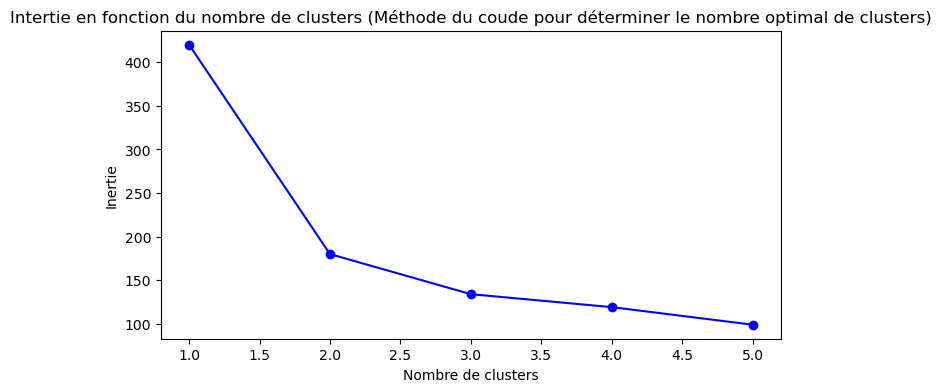

Graphiquement le nombre optimal de clusters est : 2


In [24]:
# Recherche du nombre de clusters optimals (en se limitant à 5)
nb_clusters_optimal = determine_optimal_clusters(table_cluster, 5)

In [ ]:
# clustering par méthode K-means avec 2 clusters (et ajout de la colonne donnant le Cluster sur la table_cluster) 
clusters = clustering_K_means(table_cluster,2)

# Renommage des clusters en 1 et 2
table_cluster['Cluster'] = table_cluster['Cluster'].replace({0: 1, 1: 2})

# Visualisation des moyennes des différentes variables étudiées pour chaque groupe(cluster).
table_cluster.groupby('Cluster').mean().round(2)

,f,"f,m",m,Action,Animation,Aventure,Biopic,Comédie,Comédie dramatique,Drame,Epouvante-horreur,Fantastique,Policier,Science Fiction,Thriller
Cluster,,,,,,,,,,,,,,,
1,3.73,3.70,3.73,3.42,4.02,3.75,3.80,3.67,3.75,3.84,3.56,3.42,3.80,3.57,3.57
2,3.16,3.19,3.13,2.86,3.53,3.16,3.35,2.99,3.23,3.30,2.78,2.95,3.19,3.00,2.96


Les trois premières colonnes concernent le genre du prénom du réalisateur (féminin (**f**), prenom mixte (**f,m**) ou masculin (**m**)). Nous pouvons notamment observer que le Cluster 1, peu importe le genre du prénom du réalisateur, attribue de meilleures notes que les presses du Cluster 2.

Nous pouvons à présent regarder quelles presses sont mises ensemble, ainsi que les moyennes des notes attribuées aux films, selon divers critères, au sein de chaque groupe (cluster).

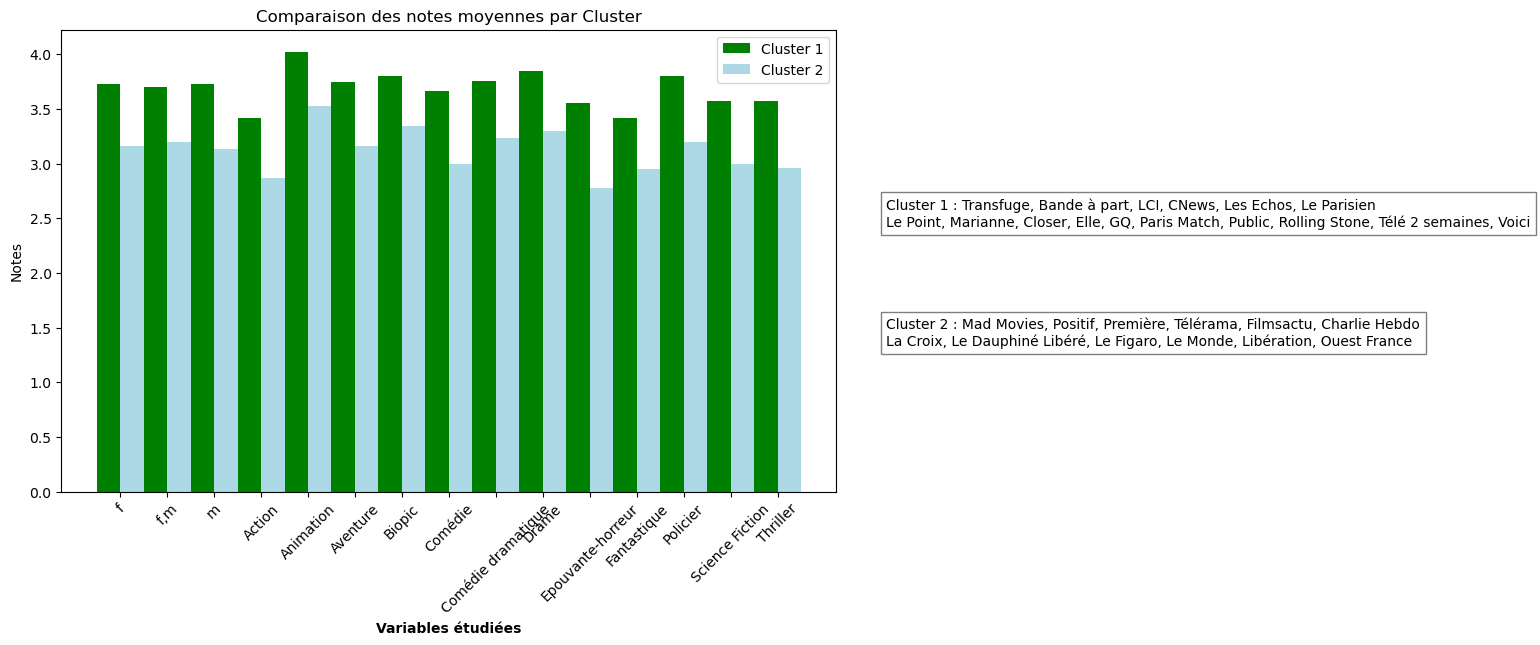

In [41]:
graphe_cluster(table_cluster)

Le Cluster 1 est composé de presse qui donnent globalement les notes les plus élevées. On retrouve dans une certaine mesure la typologie de presse retenue par Karim Hammou, Audrey Mariette, Nicolas Robette et Laure de Verdalle dans leur article "Survivre à son premier film". Etudiant les longs métrages produits en France ou en co-productions avec une société française, ils font en effet la distinction entre une presse dite "intellectuelle" (dans laquelle ils intègrent Télérama, Le Monde, Libération, Les Cahiers du Cinéma et Positif) et la presse dite "commerciale" (Le Parisien, on pourrait ajouter Paris Match). La presse commerciale note moins sévèrement que la presse intellectuelle. 

Mais ces résultats sont à nuancer car le journal "Première" qu'ils classent dans la presse "commerciale" apparaît ici dans le deuxième cluster, soit aux côtés des journaux "Le Monde", "Libération", etc.
